**Import libraries**

In [2]:
import numpy as np 
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Data Expoloration and visualisation

In [2]:
df = pd.read_csv("C:/Users/Probook/Documents/graduation project/emotion_data.csv")
print(df.shape)
df.head()

(751, 97)


,emotion,avg_color_0,avg_color_1,avg_color_2,texture_0,texture_1,texture_2,texture_3,edge_percentage,color_hist_8,...,color_hist_86,color_hist_87,color_hist_88,color_hist_89,color_hist_90,color_hist_91,color_hist_92,color_hist_93,color_hist_94,color_hist_95
0,fear,86.137451,124.000671,170.338379,462.016865,531.974454,0.179456,0.135579,0.121277,1251,...,545,630,633,738,755,811,1000,1461,1450,1649
1,fear,148.948181,165.097107,188.117737,397.551091,361.357391,0.193175,0.198448,0.137878,417,...,466,440,524,605,1204,1710,2180,3167,748,0
2,fear,122.320312,151.434082,184.770386,251.096974,426.820188,0.229898,0.185017,0.126526,496,...,255,228,318,422,791,1626,2180,3451,1815,53
3,fear,101.370972,134.759582,162.111206,323.591518,218.133929,0.117470,0.132895,0.142944,647,...,564,523,676,874,1067,1317,1349,1143,49,0
4,fear,54.886963,150.019959,189.830322,183.950397,255.876488,0.143941,0.139224,0.090393,575,...,861,892,1107,1507,1678,1669,1729,1663,1535,139


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 97 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   emotion          751 non-null    object 
 1   avg_color_0      751 non-null    float64
 2   avg_color_1      751 non-null    float64
 3   avg_color_2      751 non-null    float64
 4   texture_0        751 non-null    float64
 5   texture_1        751 non-null    float64
 6   texture_2        751 non-null    float64
 7   texture_3        751 non-null    float64
 8   edge_percentage  751 non-null    float64
 9   color_hist_8     751 non-null    int64  
 10  color_hist_9     751 non-null    int64  
 11  color_hist_10    751 non-null    int64  
 12  color_hist_11    751 non-null    int64  
 13  color_hist_12    751 non-null    int64  
 14  color_hist_13    751 non-null    int64  
 15  color_hist_14    751 non-null    int64  
 16  color_hist_15    751 non-null    int64  
 17  color_hist_16   

In [4]:
df["emotion"].unique()

array(['fear', 'anger', 'joy', 'sadness', 'surprise', 'natural'],
      dtype=object)

In [5]:
df['emotion'].value_counts()

emotion
joy         345
sadness     199
anger        67
surprise     63
natural      48
fear         29
Name: count, dtype: int64

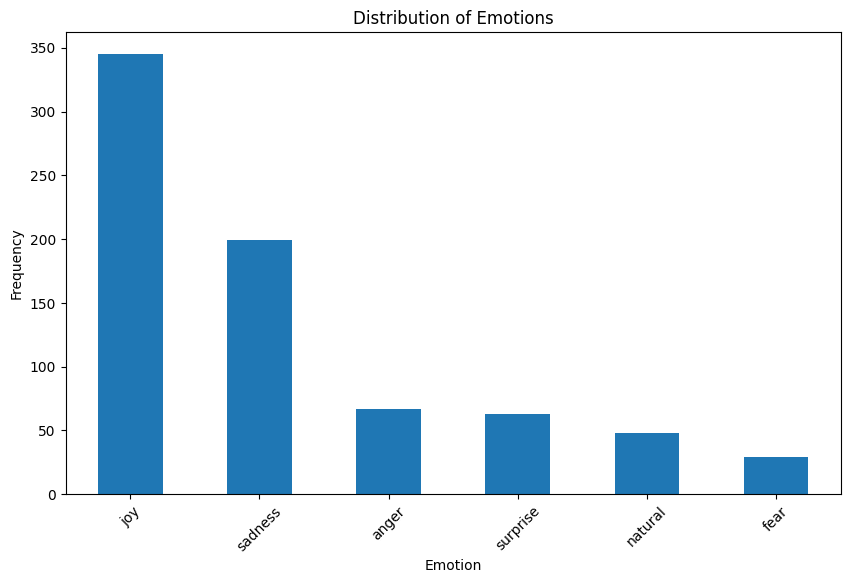

In [6]:
# Counting the frequency of each emotion
emotion_counts = df['emotion'].value_counts()

# Creating the bar chart
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [7]:
avg_color=df[["emotion","avg_color_0","avg_color_1","avg_color_2"]]
avg_color

,emotion,avg_color_0,avg_color_1,avg_color_2
0,fear,86.137451,124.000671,170.338379
1,fear,148.948181,165.097107,188.117737
2,fear,122.320312,151.434082,184.770386
3,fear,101.370972,134.759582,162.111206
4,fear,54.886963,150.019959,189.830322
...,...,...,...,...
746,natural,105.580933,113.174072,137.243347
747,natural,80.677673,95.413696,117.092102
748,natural,67.039001,83.878235,130.544006
749,natural,82.016418,98.411621,114.733215


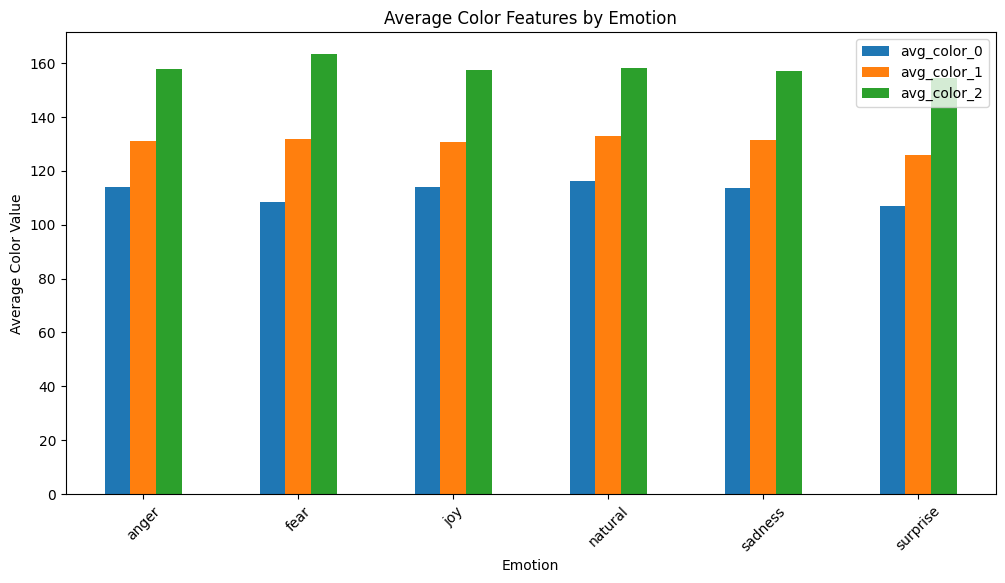

In [8]:
# Grouping by emotion and calculating the mean for each color feature
grouped_data = avg_color.groupby('emotion').mean()

# Plotting the average color features for each emotion
grouped_data.plot(kind='bar', figsize=(12, 6))
plt.title('Average Color Features by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Color Value')
plt.xticks(rotation=45)
plt.show()

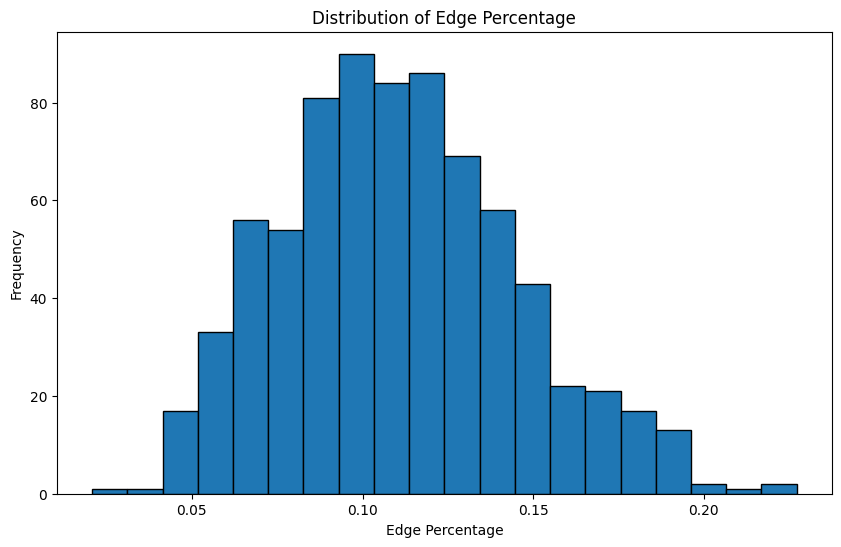

In [9]:
# Plotting the histogram for edge_percentage
plt.figure(figsize=(10, 6))
df['edge_percentage'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Edge Percentage')
plt.xlabel('Edge Percentage')
plt.ylabel('Frequency')
plt.show()

# Evaluating the models



One of the important ways humans display emotions is through facial expressions. Facial expression recognition is one of the most powerful, natural and immediate means for human beings to communicate their emotions and intensions. Humans can be in some circumstances restricted from showing their emotions, such as hospitalized patients, or due to deficiencies; hence, better recognition of other human emotions will lead to effective communication. Automatic human emotion recognition has received much attention recently with the introduction of IOT and smart environments at hospitals, smart homes and smart cities. Intelligent personal assistants (IPAs), such as Siri, Alexia, Cortana and others, use natural language processing to communicate with humans, but when augmented with emotions, it increases the level of effective communication and human-level intelligence.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr1.jpg)

A convolutional neural network was used in our system to obtain improved facial emotion detection as it is applied to other computer fields such as face recognition and object detection. In addition, predictions are based on information given at a particular time.

Fig shows the network structure that is used for emotion detection using facial landmarks. This network takes an input image and attempts to predict the output emotion.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr6.jpg)

# **Load Data and Plot Samples**

In [1]:
TRAIN_DIR = ("C:\\Users\\Probook\\Documents\\graduation project\\Dataset\\Autistic Children Emotions - Dr. Fatma M. Talaat\\Train")
TEST_DIR = ("C:\\Users\\Probook\\Documents\\graduation project\\Dataset\\Autistic Children Emotions - Dr. Fatma M. Talaat\\Test")

In [3]:
IMG_SIZE= (224, 224)

In [4]:
def load_data(dir_path, IMG_SIZE):
    X = []
    y = []
    i = 0
    labels = dict()

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            folder_path = os.path.join(dir_path, path)  # Correctly join the path

            for file in os.listdir(folder_path):
                if not file.startswith('.'):
                    file_path = os.path.join(folder_path, file)  # Correctly join the path
                    img = cv2.imread(file_path)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [5]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

758 images loaded from C:\Users\Probook\Documents\graduation project\Dataset\Autistic Children Emotions - Dr. Fatma M. Talaat\Train directory.


In [6]:
train_labels

{0: 'Natural', 1: 'anger', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}

In [7]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 20.96it/s]

75 images loaded from C:\Users\Probook\Documents\graduation project\Dataset\Autistic Children Emotions - Dr. Fatma M. Talaat\Test directory.


# **Model Building**

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

![](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

**Encoding Classes**

Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [8]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(758, 6)

In [9]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(75, 6)

In [10]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [11]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))



In [12]:
epochs = 40
batch_size=32

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

def deep_model(model, X_train, Y_train, epochs, batch_size):
   
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42) 
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    # Fit the model
    history = model.fit(
        datagen.flow(X_train, Y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) / batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, Y_val))
    
    return history


In [14]:
history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/40


18/18 [==============================] - 276s 15s/step - loss: 1.8799 - accuracy: 0.3795 - val_loss: 1.4938 - val_accuracy: 0.4671
Epoch 2/40
18/18 [==============================] - 269s 14s/step - loss: 1.4809 - accuracy: 0.4571 - val_loss: 1.4643 - val_accuracy: 0.4408
Epoch 3/40
18/18 [==============================] - 278s 15s/step - loss: 1.4540 - accuracy: 0.4340 - val_loss: 1.5700 - val_accuracy: 0.4671
Epoch 4/40
18/18 [==============================] - 276s 15s/step - loss: 1.4778 - accuracy: 0.4406 - val_loss: 1.4766 - val_accuracy: 0.4671
Epoch 5/40
18/18 [==============================] - 281s 15s/step - loss: 1.4505 - accuracy: 0.4587 - val_loss: 1.4658 - val_accuracy: 0.4737
Epoch 6/40
18/18 [==============================] - 279s 15s/step - loss: 1.4246 - accuracy: 0.4571 - val_loss: 1.3540 - val_accuracy: 0.5197
Epoch 7/40
18/18 [==============================] - 270s 14s/step - loss: 1.4812 - accuracy: 0.4604 - val_loss: 1.2628 - val_accuracy: 0.5263
Epoc

**Validation and test set accuracy and loss**



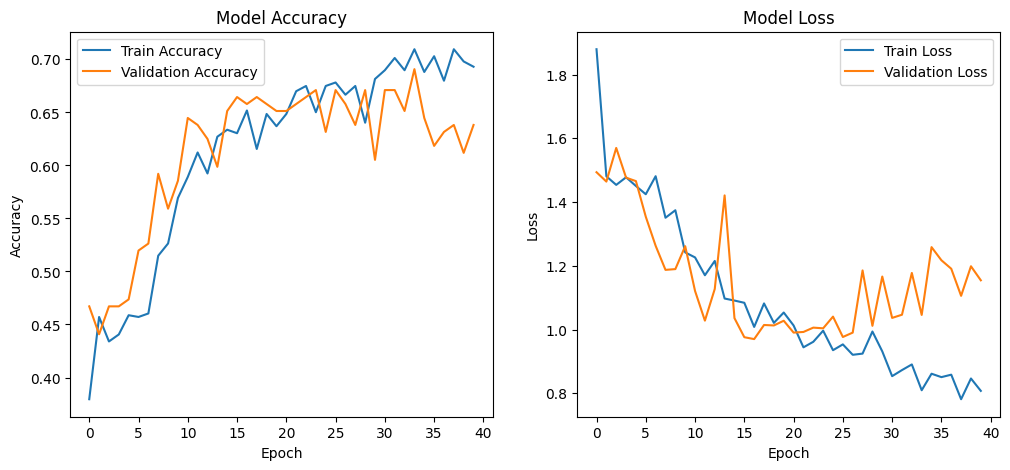

In [22]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')



**Let's try our model and make predictions**

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 75 images belonging to 6 classes.


In [17]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

3/3 [==============================] - 10s 3s/step


In [18]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [19]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Natural\017.jpg,sadness,Natural
1,Natural\022.jpg,sadness,Natural
2,Natural\026.jpg,sadness,Natural
3,Natural\057.jpg,sadness,Natural
4,Natural\059.jpg,sadness,Natural


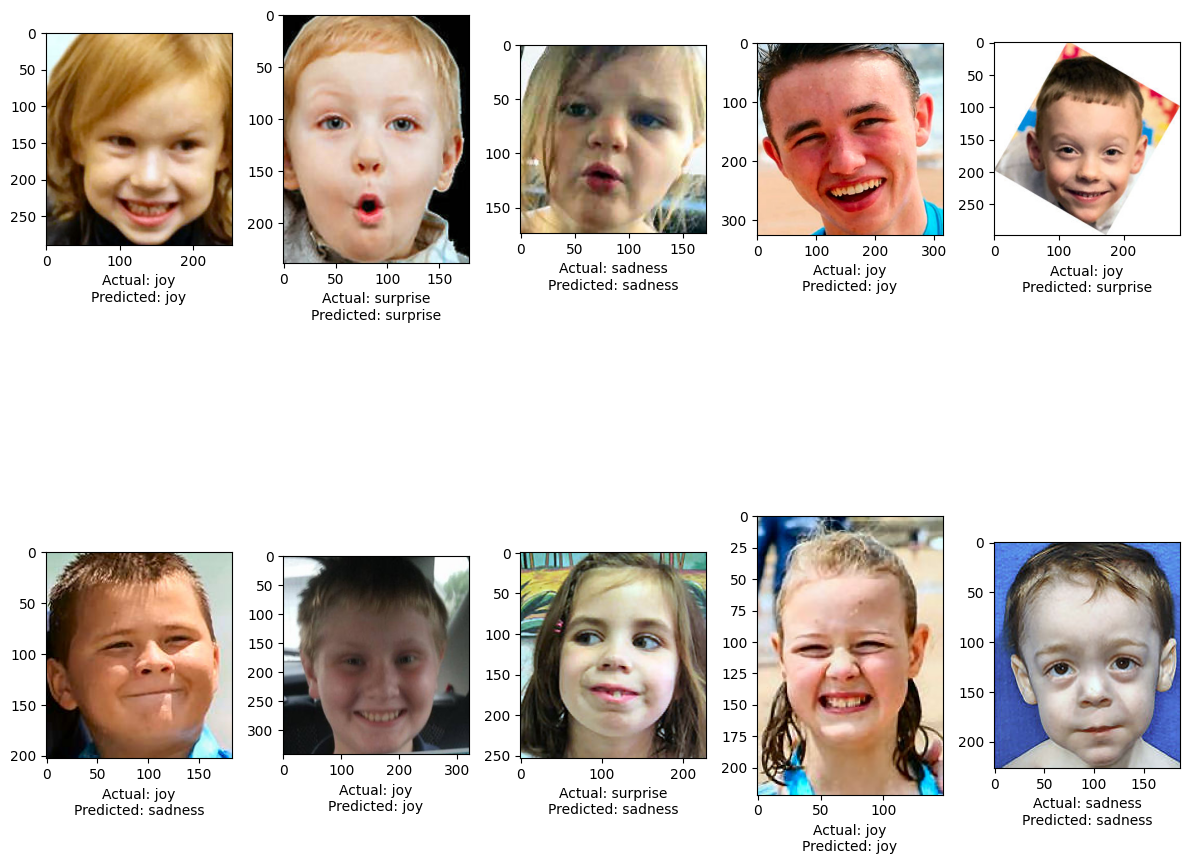

In [20]:
# Assuming pred_result, TEST_DIR, and filenames are defined as before
l = len(filenames)
base_path = TEST_DIR

plt.figure(figsize=(12, 12))

for i in range(10):  # 10 images
    rnd_number = np.random.choice(range(l))
    filename, pred_class, actual_class = pred_result.loc[rnd_number]

    img_path = os.path.join(base_path, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.xlabel(f"Actual: {actual_class}\nPredicted: {pred_class}")

plt.tight_layout()
plt.show()


# CNN based on MobileNet model

##  Construction of the third model (MobileNet)
The MobileNet model proposed by Howard et al. (2017), is a CNN architecture that were created to perform computer vision tasks on mobile devices and embedded systems. They are based on in-depth separable convolution operations, which lessens the burden of operations in the first layers.

<p><img src = "https://nitheshsinghsanjay.github.io/images/mobtiny_fig.PNG" alt></p>

###### Step 1 - Base model creation

In [11]:
from tensorflow.keras.utils import to_categorical

# Convert class vectors to binary class matrices (
num_classes = 6  # Adjust based on your dataset
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)



In [12]:
# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [27]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
batch_size = 32
# Assume num_classes is already defined as 6
num_classes = 6
input_shape = (224, 224, 3)
# Base MobileNet model
CNN_base_mobilenet = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')

# Build the model
model = Sequential()
model.add(CNN_base_mobilenet)

# Add a new Dense layer with some units, e.g., 256
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 3492806 (13.32 MB)
Trainable params: 3470918 (13.24 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)


In [16]:
# Start of counting time
start = dt.datetime.now()

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=50,
    validation_data=(X_test, y_test)
)

# End of Time Counting
end = dt.datetime.now()
print('Training and validation time: ', end - start)


Epoch 1/50


23/23 [==============================] - 60s 2s/step - loss: 1.8640 - accuracy: 0.3892 - val_loss: 1.5824 - val_accuracy: 0.5333
Epoch 2/50
23/23 [==============================] - 51s 2s/step - loss: 1.4023 - accuracy: 0.5290 - val_loss: 1.8815 - val_accuracy: 0.1333
Epoch 3/50
23/23 [==============================] - 49s 2s/step - loss: 1.2732 - accuracy: 0.5317 - val_loss: 1.6668 - val_accuracy: 0.2400
Epoch 4/50
23/23 [==============================] - 62s 3s/step - loss: 1.1082 - accuracy: 0.6121 - val_loss: 1.8564 - val_accuracy: 0.1333
Epoch 5/50
23/23 [==============================] - 50s 2s/step - loss: 0.9968 - accuracy: 0.6332 - val_loss: 1.8801 - val_accuracy: 0.1333
Epoch 6/50
23/23 [==============================] - 50s 2s/step - loss: 0.9117 - accuracy: 0.6649 - val_loss: 1.7191 - val_accuracy: 0.1333
Epoch 7/50
23/23 [==============================] - 50s 2s/step - loss: 0.9169 - accuracy: 0.6675 - val_loss: 1.7807 - val_accuracy: 0.1333
Epoch 8/50
23/23 [

In [17]:
# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.1068004369735718
Test accuracy: 0.7733333110809326


In [28]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 75 images belonging to 6 classes.


In [31]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [35]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Natural\017.jpg,anger,Natural
1,Natural\022.jpg,anger,Natural
2,Natural\026.jpg,anger,Natural
3,Natural\057.jpg,anger,Natural
4,Natural\059.jpg,anger,Natural


In [33]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

3/3 [==============================] - 1s 151ms/step


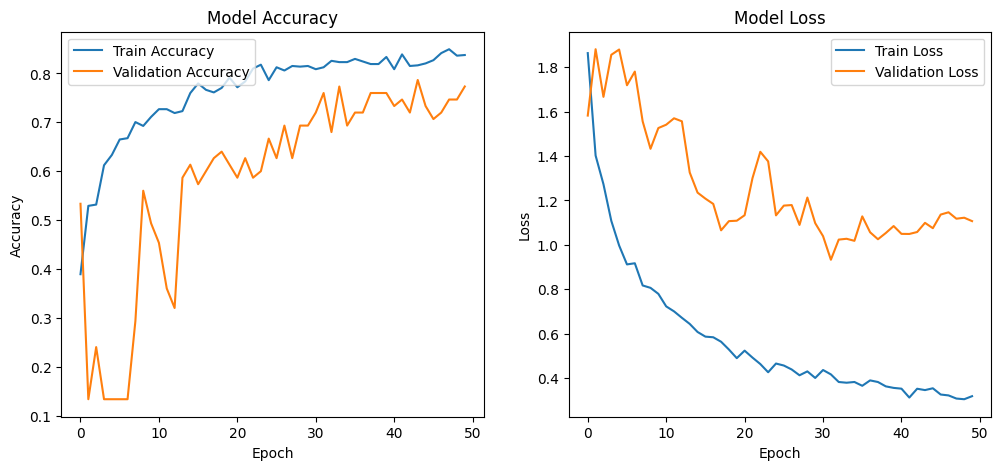

In [38]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')



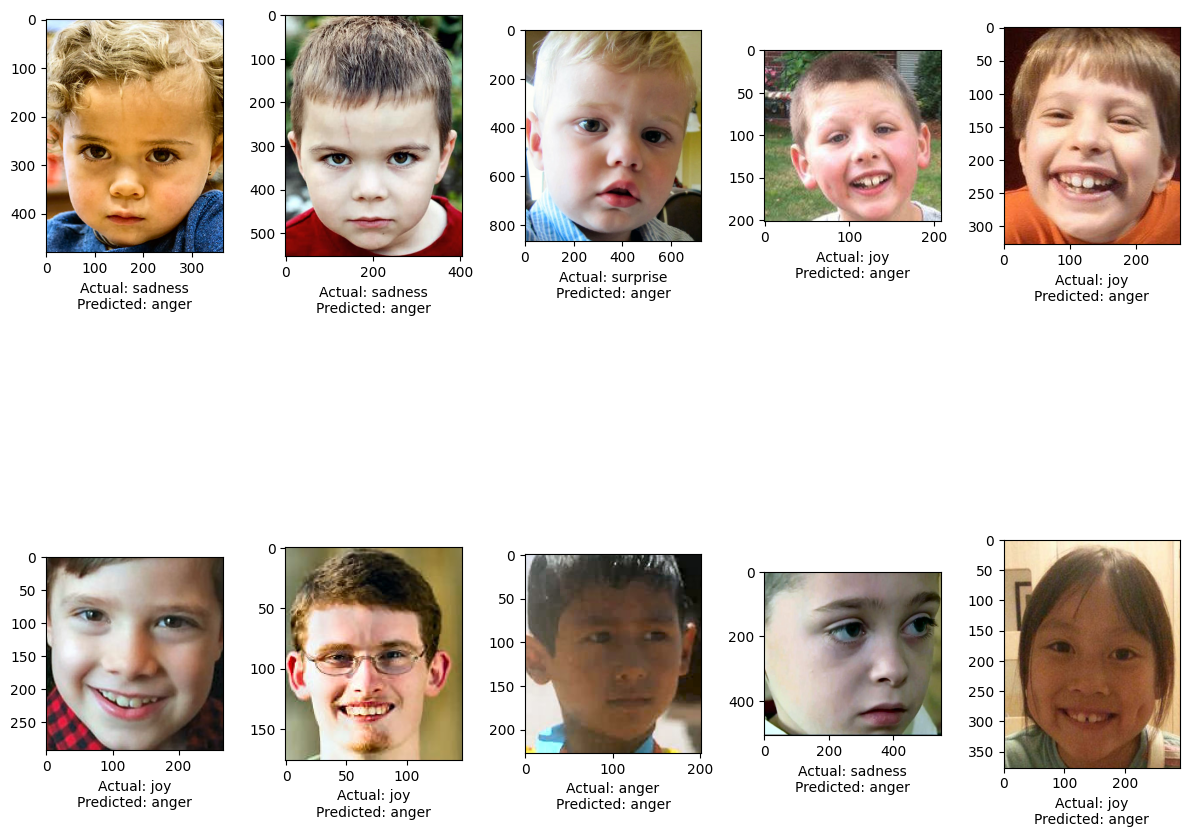

In [37]:
# Assuming pred_result, TEST_DIR, and filenames are defined as before
l = len(filenames)
base_path = TEST_DIR

plt.figure(figsize=(12, 12))

for i in range(10):  # 10 images
    rnd_number = np.random.choice(range(l))
    filename, pred_class, actual_class = pred_result.loc[rnd_number]

    img_path = os.path.join(base_path, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.xlabel(f"Actual: {actual_class}\nPredicted: {pred_class}")

plt.tight_layout()
plt.show()
